In [1]:
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse
import scipy.optimize

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')

In [2]:
def rebin_factor(n_bin): #use bootstraps instead
    return (2.0*np.sqrt(n_bin/1000.0)+n_bin/1000.0-2.0*np.sqrt(1.0/1000.0)-1.0/1000.0)
def params_file(rebin):
    return os.path.join("C103 rebin fits",f"param_samplings_new_hexaquark_rebin{rebin}.hdf5")
def variance_of_err(bootstraps):
    mean = bootstraps[0]
    mean_err = utils.bootstrap_error_by_array(bootstraps)
    err_bootstraps = [mean_err]
    for i in range(1,len(bootstraps)):
        new_bootstraps = np.append(bootstraps[:i],bootstraps[i+1:])
#         new_bootstraps = np.append(bootstraps[i:],bootstraps[:i])
        err_bootstraps.append(utils.bootstrap_error_by_array(new_bootstraps))
    return np.array(err_bootstraps)

In [3]:
fit = r"$m_N$"
#jackknife analysis
datasets = {
    r"bootstrap $N_B=800$": {
        1: {"val":0.702646965314, "err":0.000362419052005, "chisqrdof":0.530676491881},
        2: {"val":0.702674650839, "err":0.000368947021752, "chisqrdof":0.560606380656},
        5: {"val":0.70265, "err":0.00041 , "chisqrdof":0.55},
        10: {"val":0.702471872096, "err":0.000438126519094, "chisqrdof":0.707427519047},
        15: {"val":0.702545665211, "err":0.000416715153997, "chisqrdof":0.766100846697},
#         20: {"val":, "err":, "chisqrdof":},
    }
}
chosen_value = {"rebin":2,"dataset":"bootstrap $N_B=800$"}

In [4]:
bootstrap_rebin = [1,2,5,10,15]
bootstrap_datasets = {}
for rebin in bootstrap_rebin:
    with h5py.File(params_file(rebin)) as file:
        bootstrap_datasets[rebin] = {}
        bootstrap_datasets[rebin]['N'] = {}
        bootstrap_datasets[rebin]['N']["data"] = file['Values']['Values']['<MCObservable><Info>20000G1g-N-SS_0-0T6-25 4 n re<|Info><|MCObservable>'][()]
        bootstrap_datasets[rebin]['NN'] = {}
        bootstrap_datasets[rebin]['NN']["data"] = file['Values']['Values']['<MCObservable><Info>10000T1g-ROT-0T5-15 24 n re<|Info><|MCObservable>'][()]


In [5]:

for rebin in bootstrap_rebin:
    for corr in ["N", "NN"]:
         bootstrap_datasets[rebin][corr]["errs"] = variance_of_err(bootstrap_datasets[rebin][corr]["data"])
            
    

In [6]:
len(bootstrap_datasets[1]["N"]["errs"])

801

In [7]:
#fit relative error rebin, chisqr vs rebin
for dataset in datasets:
    for rebin in datasets[dataset]:
        datapoint = datasets[dataset][rebin]
        datapoint["rel_err"] = datapoint["err"]/datapoint["val"]
        if rebin>1:
            datapoint["sigma_ratio"] = datapoint["err"]*datapoint["err"]/datasets[dataset][1]["err"]/datasets[dataset][1]["err"]
            datapoint["sigma_ratio_err"] = datapoint["sigma_ratio"]*rebin_factor(rebin)
        else:
            datapoint["sigma_ratio"] = 1.0
            datapoint["sigma_ratio_err"] = 0.0

[4.82783247e-07 5.06067442e-07 5.67478632e-07 5.97011611e-07
 5.91383508e-07]
[4.53082903e-07 5.16310200e-07 5.51105998e-07 5.34268977e-07
 5.36604158e-07]


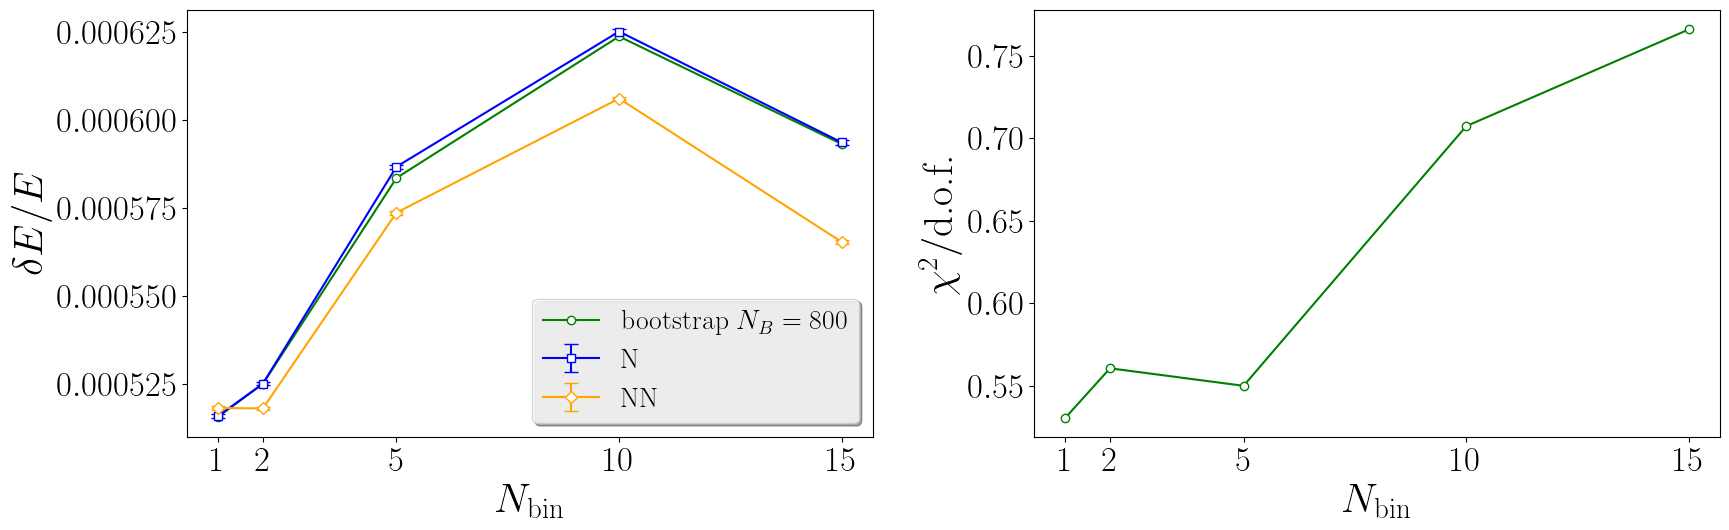

In [8]:
fig, axes = plt.subplots(1,2)
fig.set_figwidth(18)
fig.set_figheight(6)

for i,dataset in enumerate(datasets):
    x = np.array(list(datasets[dataset].keys()))
    y = np.array([datasets[dataset][rebin]["rel_err"] for rebin in datasets[dataset]])
    axes[0].plot(x,y,label=dataset, color=settings.colors[i], marker=settings.markers[i], mfc="white",zorder = 2)
    chi = np.array([datasets[dataset][rebin]["chisqrdof"] for rebin in datasets[dataset]])
    axes[1].plot(x,chi,label=dataset, color=settings.colors[i], marker=settings.markers[i], mfc="white",zorder = 2)
    
# for i,dataset in enumerate(bootstrap_datasets):
x = np.array(list(bootstrap_datasets.keys()))
for corr in ["N", "NN"]:
    y = np.array([bootstrap_datasets[rebin][corr]["errs"][0]/bootstrap_datasets[rebin][corr]["data"][0] for rebin in datasets[dataset]])
    yerr = np.array([ utils.bootstrap_error_by_array(bootstrap_datasets[rebin][corr]["errs"]/bootstrap_datasets[rebin][corr]["data"]) for rebin in datasets[dataset]])
    print(yerr)
    axes[0].errorbar(x=x,y=y,yerr=yerr,label=corr, color=settings.colors[i+len(datasets)], marker=settings.markers[i+len(datasets)], mfc="white",elinewidth=1.5,capsize=5,zorder = 2)
    i+=1
    
axes[0].set_xlabel(r"$N_{\textup{bin}}$")
axes[0].set_xticks(ticks=x)
axes[1].set_xlabel(r"$N_{\textup{bin}}$")
axes[1].set_xticks(ticks=x)
axes[0].set_ylabel(r"$\delta E/E$")
axes[1].set_ylabel(r"$\chi^2/\textup{d.o.f.}$")
axes[0].legend()
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

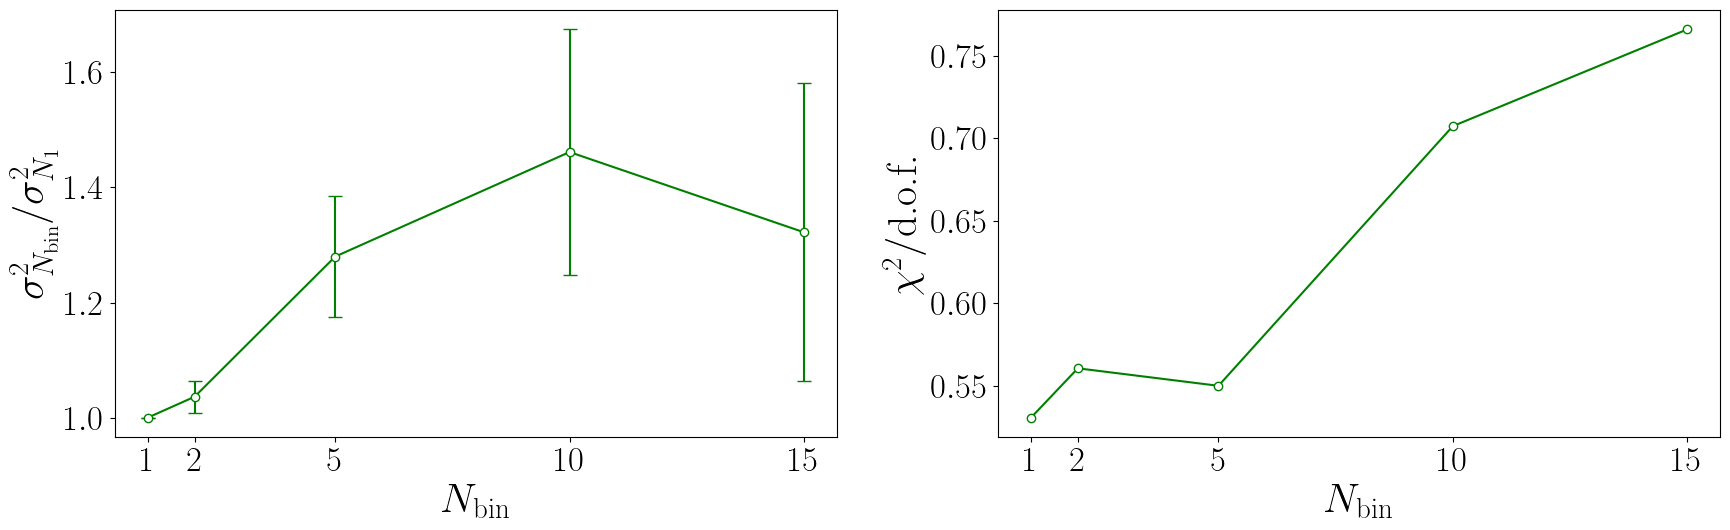

In [9]:
plt.clf()
fig, axes = plt.subplots(1,2)
fig.set_figwidth(18)
fig.set_figheight(6)

for i,dataset in enumerate(datasets):
    x = np.array(list(datasets[dataset].keys()))
    y = np.array([datasets[dataset][rebin]["sigma_ratio"] for rebin in datasets[dataset]])
    yerr = np.array([datasets[dataset][rebin]["sigma_ratio_err"] for rebin in datasets[dataset]])
    axes[0].errorbar(x=x,y=y,yerr=yerr,label=dataset, color=settings.colors[i],elinewidth=1.5,capsize=5, marker=settings.markers[i], mfc="white",zorder = 2)
    chi = np.array([datasets[dataset][rebin]["chisqrdof"] for rebin in datasets[dataset]])
    axes[1].plot(x,chi,label=dataset, color=settings.colors[i], marker=settings.markers[i], mfc="white",zorder = 2)
    
axes[0].set_xlabel(r"$N_{\textup{bin}}$")
axes[0].set_xticks(ticks=x)
axes[1].set_xlabel(r"$N_{\textup{bin}}$")
axes[1].set_xticks(ticks=x)
axes[0].set_ylabel(r"$\sigma^2_{N_{\textup{bin}}}/\sigma^2_{N_{1}}$")
axes[1].set_ylabel(r"$\chi^2/\textup{d.o.f.}$")
plt.tight_layout()
